In [8]:
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
from qiskit.quantum_info import OneQubitEulerDecomposer
from qiskit.quantum_info import TwoQubitBasisDecomposer
from qiskit.circuit.library.standard_gates import CZGate
from qiskit.quantum_info.operators import Operator

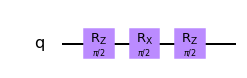

In [47]:
def oneQubitDecomppser(Gate):
    """
    Decomposes a single qubit gate to the Rx,Rz basis
    
    Parameters:
    Gate (qiskit Gate object): qiskit quantum gate object "https://qiskit.org/documentation/stubs/qiskit.circuit.Gate.html".
    
    Returns:
    QuantumCircuit: Qiskit quantum circuit which contains the decomposition.
    """
    oneQubitDecomposer = OneQubitEulerDecomposer(basis="ZXZ")
    op=Operator(Gate)
    decomposition = oneQubitDecomposer.__call__(op)
    return decomposition

#testing

qc=QuantumCircuit(1)
qc.h(0)
hgate=qc.data[0][0]
oneQubitDecomppser(hgate).draw(output="mpl")


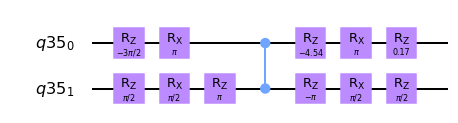

In [48]:
def twoQubitDecomppser(Gate):
    """
    Decomposes a two qubit gate to the Rx,Rz,cz basis
    
    Parameters:
    Gate (qiskit Gate object): qiskit quantum gate object "https://qiskit.org/documentation/stubs/qiskit.circuit.Gate.html".
    
    Returns:
    QuantumCircuit: Qiskit quantum circuit which contains the decomposition.
    """
    twoQubitDecomposer=TwoQubitBasisDecomposer(gate=CZGate(), basis_fidelity=1.0, euler_basis="ZXZ")
    op=Operator(Gate)
    decomposition = twoQubitDecomposer.__call__(op)
    return decomposition

#testing

qc=QuantumCircuit(2)
qc.cx(0,1)
cxgate=qc.data[0][0]
twoQubitDecomppser(cxgate).draw(output="mpl")


                   
q_0: ──■───────────
     ┌─┴─┐         
q_1: ┤ X ├─────────
     ├───┤         
q_2: ┤ H ├─────────
     └───┘         
q_3: ──■───■──■──■─
       │   │  │  │ 
q_4: ──■───■──■──■─
                   


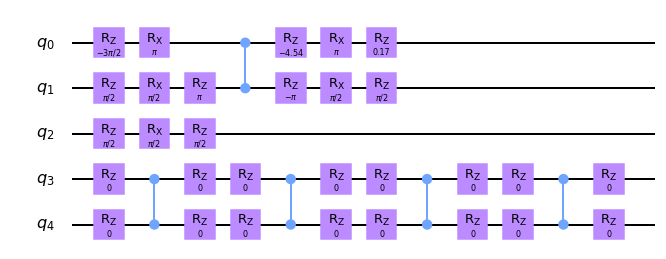

In [49]:
def compiler(circuit):
    """
    Translates one quantum circuit into another, using a restricted set of gates {Rx,Rz,cz}.
    
    Parameters:
    circuit (QuantumCircuit): qiskit QuantumCircuit object which contains the gates.
    
    Returns:
    QuantumCircuit: An equivalent quantum circuit which contains {Rx,Rz,cz} decomposition.
    """
    #initialize an empty circuit with the same size of qubits and clbits 
    decomposedCircuit = QuantumCircuit(circuit.num_qubits)
    if circuit.num_clbits >0:
        decomposedCircuit.add_register(ClassicalRegister(circuit.num_clbits))
    
    #extract the gates to compile them from the data list
    for item in circuit.data:
        
        #the gate object
        gate=item[0] 
        
        #number of qubits of the gate
        numOfQubits=len(item[1]) 
        
        #the indices that the gate applied on
        positions=[qubit.index for qubit in item[1]] 
        
        #check if the gate is a single qubit gate
        if numOfQubits==1:
            #decompose the single qubit gate
            decomposition=oneQubitDecomppser(gate)
            #extract the decomposition gates from the received circuit
            gates=[item[0] for item in decomposition.data]
            #append each gate to the new circuit at the same position    note: len(positions)=1 "single qubit gate"
            [decomposedCircuit.append(gate,positions) for gate in gates]
        
        #check if the gate is a two qubit gate
        elif numOfQubits==2:
            #decompose the gate
            decomposition=twoQubitDecomppser(gate)
            #extract the decomposition gates from the received circuit
            for item in decomposition.data:
                gate=item[0]
                if len(item[1])==2:
                    #append each gate to the new circuit at the same positions   note: len(positions)=2
                    decomposedCircuit.append(gate,positions)
                else:
                    #append a single qubit gate to the new circuit
                    #get the index (0 or 1) means the gate is applied to the 1st qubit or the 2nd qubit from the positions list 
                    decomposedCircuit.append(gate,[positions[item[1][0].index]])                 
    
    return decomposedCircuit

#testing
qc=QuantumCircuit(5)
qc.cx(0,1)
qc.h(2)
qc.cz(3,4)
qc.cz(3,4)
qc.cz(3,4)
qc.cz(3,4)
print(qc)
newCircuit=compiler(qc)
newCircuit.draw(output="mpl")

In [50]:
#overhead
#1.rotations with zero angles
#2.double rotation about the same axis (we can combine them)
#3.doublicate cz gates (remove each other)

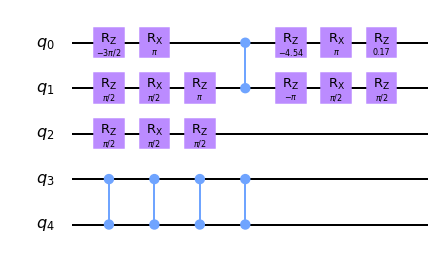

In [51]:
def removeZeroRotations(circuit):
    """
    Removes rotations with zero angles.
    
    Parameters:
    circuit (QuantumCircuit): circuit before simplification.
    
    Returns:
    QuantumCircuit: A quantum circuit without gates with zero rotation.
    """
    n=len(circuit.data)
    i=0
    while i<n:
        if circuit.data[i][0].params==[0.0]:
            circuit.data.pop(i)
            i=i-1
            n=n-1
        i=i+1
    return circuit


#testing
newCircuit=removeZeroRotations(newCircuit)
newCircuit.draw(output="mpl")

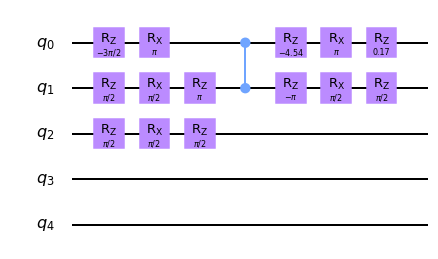

In [52]:
def removeDoubleCZ(circuit):
    """
    Removes pairs of cz at the same positions to optimize the circuit.
    
    Parameters:
    circuit (QuantumCircuit): circuit before simplification.
    
    Returns:
    QuantumCircuit: A quantum circuit after simplification.
    """
    wires=[[""] for i in range(circuit.num_qubits)]
    n=len(circuit.data)
    i=0
    while i<n:
        if circuit.data[i][0].name=="cz":
            qubit1=circuit.data[i][1][0].index
            qubit2=circuit.data[i][1][1].index
            if wires[qubit1][-1][:2]=="cz" and wires[qubit2][-1][:2]=="cz":
                circuit.data.pop(i)
                circuit.data.pop(int(wires[qubit1][-1][2:]))
                wires[qubit1].pop()
                wires[qubit2].pop()
                i=i-2
                n=n-2
            else:
                wires[qubit1].append("cz"+str(i))
                wires[qubit2].append("cz"+str(i))
        else:
            qubit=circuit.data[i][1][0].index
            wires[qubit].append(circuit.data[i][0].name)
        i=i+1
    return circuit

#testing
newCircuit=removeDoubleCZ(newCircuit)
newCircuit.draw(output="mpl")